In [1]:
# =========================
# 1. Install dependencies
# =========================
!pip install -U openai numpy pandas scipy tabulate matplotlib

In [2]:
# =========================
# 2. Import library
# =========================
import os
import time
import json
import math
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from openai import OpenAI
from scipy.stats import norm
from tabulate import tabulate

In [11]:
# =========================
# 3. Configure DeepSeek API
# =========================
from openai import OpenAI
from google.colab import userdata
import random
import numpy as np

DEEPSEEK_API_KEY = userdata.get("DEEPSEEK_API_KEY")

if not DEEPSEEK_API_KEY:
    raise ValueError("DEEPSEEK_API_KEY is empty. Please set it in Colab Secrets first.")

client = OpenAI(
    api_key=DEEPSEEK_API_KEY,
    base_url="https://api.deepseek.com"
)

MODEL_NAME = "deepseek-chat"

# Baseline: 1
# Modification: 0
TEMPERATURE = 1
OUTPUT_FILE = "all_trials_verbal_temp1.json"

N_LIST = [1, 3]
BLOCKS = 2

# Common settings for verbal tasks in the original paper
ALPHABET = "bcdfghjklnpqrstvwxyz"
SEQ_LENGTH = 24
MATCHES = 8

# Fixed random seed for easy reproduction
RANDOM_SEED = 42
random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)

# Output filename
OUTPUT_FILE = f"all_trials_verbal_temp{TEMPERATURE}.json"

print("DeepSeek client ready")
print("model:", MODEL_NAME)
print("temperature:", TEMPERATURE)
print("blocks:", BLOCKS)
print("key length:", len(DEEPSEEK_API_KEY))
print("key prefix:", DEEPSEEK_API_KEY[:5])

DeepSeek client ready
model: deepseek-chat
temperature: 1
blocks: 2
key length: 35
key prefix: sk-bb


In [4]:
# =========================
# 4. Generate verbal n-back sequences
# =========================
def generate_nback_sequences(n, alphabet, seq_length, matches, num_sequences):
    sequences = []

    for _ in range(num_sequences):
        seq = []
        conditions = []

        match_positions = random.sample(range(n, seq_length), matches)
        match_positions.sort()

        for i in range(seq_length):
            if i in match_positions:
                # Forced construction of match
                seq.append(seq[i - n])
                conditions.append("m")
            else:
                # Construct a non-match to avoid accidental n-backmatches
                random_letter = random.choice(alphabet)
                while i >= n and random_letter == seq[i - n]:
                    random_letter = random.choice(alphabet)

                seq.append(random_letter)
                conditions.append("-")

        sequences.append(("".join(seq), "".join(conditions)))

    return sequences


def build_all_trials(n_list, blocks, alphabet, seq_length, matches):
    all_trials = {}

    for n in n_list:
        sequences = generate_nback_sequences(
            n=n,
            alphabet=alphabet,
            seq_length=seq_length,
            matches=matches,
            num_sequences=blocks
        )

        for b, (seq, cond) in enumerate(sequences):
            trials = []
            for i in range(len(seq)):
                trials.append({
                    "stimulus": seq[i],
                    "target": cond[i],
                    "response": "",
                    "correct": None,
                    "rt": None
                })

            all_trials[f"{n}back_{b}"] = trials

    return all_trials


all_trials = build_all_trials(
    n_list=N_LIST,
    blocks=BLOCKS,
    alphabet=ALPHABET,
    seq_length=SEQ_LENGTH,
    matches=MATCHES
)

print("Data preparation complete.")
print("keys Example:", list(all_trials.keys())[:3])

Data preparation complete.
keys Example: ['1back_0', '1back_1', '3back_0']


In [5]:
# =========================
# 5. DeepSeek function calls (stable version)
# =========================
def normalize_response(text):
    """
    Try to normalize the model output to 'm' or '-'.
    """
    if text is None:
        return None

    text = str(text).strip().lower()

    # Exact Match
    if text == "m":
        return "m"
    if text == "-":
        return "-"

    # Common multiple output scenarios
    text = text.replace(" ", "")
    if text.startswith("m"):
        return "m"
    if text.startswith("-"):
        return "-"

    # Iterate through the list to find the first valid character
    for ch in text:
        if ch in ["m", "-"]:
            return ch

    return None


def get_model_response(messages, model_name, temperature, max_retries=3, sleep_seconds=2):
    if "client" not in globals():
        raise ValueError("client It hasn't been initialized yet. Please run the API configuration section first.")

    last_error = None

    for attempt in range(max_retries):
        try:
            start_time = time.time()

            completion = client.chat.completions.create(
                model=model_name,
                messages=messages,
                temperature=temperature,
                max_tokens=5
            )

            response_time = time.time() - start_time
            raw_text = completion.choices[0].message.content
            response = normalize_response(raw_text)

            return response, raw_text, response_time

        except Exception as e:
            last_error = e
            print(f"[API ERROR] attempt {attempt+1}/{max_retries}: {e}")
            time.sleep(sleep_seconds)

    raise RuntimeError(f"The API failed repeatedly, with the following error:{last_error}")

In [6]:
# =========================
# 6. Run a single n-back task (stable version）
# =========================
def run_nback_task(all_trials, n, blocks, model_name, temperature, output_file, sleep_between_blocks=1):
    if n == 1:
        task_instruction = (
            "You are asked to perform a 1-back task. "
            "You will see a sequence of letters one by one. "
            "Respond with 'm' whenever the current letter is the same as the previous letter, "
            "and '-' otherwise. Only output 'm' or '-'. No explanation."
        )
    elif n == 2:
        task_instruction = (
            "You are asked to perform a 2-back task. "
            "You will see a sequence of letters one by one. "
            "Respond with 'm' whenever the current letter is the same as the letter two steps ago, "
            "and '-' otherwise. Only output 'm' or '-'. No explanation."
        )
    elif n == 3:
        task_instruction = (
            "You are asked to perform a 3-back task. "
            "You will see a sequence of letters one by one. "
            "Respond with 'm' whenever the current letter is the same as the letter three steps ago, "
            "and '-' otherwise. Only output 'm' or '-'. No explanation."
        )
    else:
        raise ValueError("Currently only supports n=1/2/3")

    for b in range(blocks):
        trial_key = f"{n}back_{b}"
        messages = [{"role": "system", "content": task_instruction}]

        print(f"\n========== Running {trial_key} ==========")

        for i, trial in enumerate(all_trials[trial_key]):
            stimulus = trial["stimulus"]
            target = trial["target"]

            print(f"block {b}, trial {i}: stimulus={stimulus}, target={target}")

            messages.append({"role": "user", "content": stimulus})

            try:
                response, raw_text, rt = get_model_response(
                    messages=messages,
                    model_name=model_name,
                    temperature=temperature
                )

                trial["rt"] = rt
                trial["raw_output"] = raw_text

                # If parsing still fails, provide a default value to avoid interrupting the entire experiment.
                if response not in ["m", "-"]:
                    print(f"[WARNING] Unable to recognize output，raw={raw_text}，Default is recorded as '-'")
                    response = "-"

                trial["response"] = response
                trial["correct"] = (response == target)

                print(f"model raw: {raw_text}")
                print(f"parsed: {response}")
                print(f"rt: {rt:.2f}s")
                print("correct" if trial["correct"] else "incorrect")
                print("------------------------------------")

                messages.append({"role": "assistant", "content": response})

            except Exception as e:
                print(f"[TRIAL ERROR] block {b}, trial {i}: {e}")

                trial["rt"] = None
                trial["raw_output"] = str(e)
                trial["response"] = "ERROR"
                trial["correct"] = False


                messages.append({"role": "assistant", "content": "-"})


        with open(output_file, "w", encoding="utf-8") as f:
            json.dump(all_trials, f, ensure_ascii=False, indent=2)

        print(f"[AUTO-SAVED] {output_file}")
        time.sleep(sleep_between_blocks)

    return all_trials

In [7]:
# =========================
# 7. Officially running experiment (stable version)
# =========================
print("Start running the experiment...")
print(f"MODEL_NAME = {MODEL_NAME}")
print(f"TEMPERATURE = {TEMPERATURE}")
print(f"N_LIST = {N_LIST}")
print(f"BLOCKS = {BLOCKS}")
print(f"OUTPUT_FILE = {OUTPUT_FILE}")

for n in N_LIST:
    all_trials = run_nback_task(
        all_trials=all_trials,
        n=n,
        blocks=BLOCKS,
        model_name=MODEL_NAME,
        temperature=TEMPERATURE,
        output_file=OUTPUT_FILE,
        sleep_between_blocks=1
    )

with open(OUTPUT_FILE, "w", encoding="utf-8") as f:
    json.dump(all_trials, f, ensure_ascii=False, indent=2)

print(f"\nThe experiment is complete, and the results have been saved to: {OUTPUT_FILE}")

Start running the experiment...
MODEL_NAME = deepseek-chat
TEMPERATURE = 1
N_LIST = [1, 3]
BLOCKS = 2
OUTPUT_FILE = all_trials_verbal_temp1.json

========== Running 1back_0 ==========
block 0, trial 0: stimulus=x, target=-
model raw: -
parsed: -
rt: 2.39s
correct
------------------------------------
block 0, trial 1: stimulus=x, target=m
model raw: -
parsed: -
rt: 1.46s
incorrect
------------------------------------
block 0, trial 2: stimulus=d, target=-
model raw: -
parsed: -
rt: 1.63s
correct
------------------------------------
block 0, trial 3: stimulus=y, target=-
model raw: -
parsed: -
rt: 1.78s
correct
------------------------------------
block 0, trial 4: stimulus=y, target=m
model raw: m
parsed: m
rt: 1.56s
correct
------------------------------------
block 0, trial 5: stimulus=y, target=m
model raw: m
parsed: m
rt: 1.88s
correct
------------------------------------
block 0, trial 6: stimulus=s, target=-
model raw: -
parsed: -
rt: 1.60s
correct
--------------------------------

In [8]:
# =========================
# 8. Calculate summary stats
# =========================
def compute_summary_stats(all_trials, n_list, blocks):
    summary_stats = {}
    raw_data = {}

    for n in n_list:
        hit_rate = []
        false_alarm_rate = []
        accuracy = []
        response_time = []
        d_prime = []

        for b in range(blocks):
            trials = all_trials[f"{n}back_{b}"]

            hits = 0
            false_alarms = 0
            total_targets = 0
            total_lures = 0
            total_rt = 0

            for trial in trials:
                if trial["target"] == "m":
                    total_targets += 1
                    if trial["correct"]:
                        hits += 1
                        total_rt += trial["rt"]
                else:
                    total_lures += 1
                    if trial["response"] == "m":
                        false_alarms += 1

            hr = (hits / total_targets) * 100 if total_targets > 0 else np.nan
            far = (false_alarms / total_lures) * 100 if total_lures > 0 else np.nan
            acc = ((hits + (total_lures - false_alarms)) / (total_targets + total_lures)) * 100

            # d'
            hit_rate_adjusted = np.clip(hits / total_targets, 0.01, 0.99) if total_targets > 0 else np.nan
            false_alarm_rate_adjusted = np.clip(false_alarms / total_lures, 0.01, 0.99) if total_lures > 0 else np.nan

            if not np.isnan(hit_rate_adjusted) and not np.isnan(false_alarm_rate_adjusted):
                dp = abs(norm.ppf(hit_rate_adjusted) - norm.ppf(false_alarm_rate_adjusted))
            else:
                dp = np.nan

            mean_rt = total_rt / hits if hits > 0 else np.nan

            hit_rate.append(hr)
            false_alarm_rate.append(far)
            accuracy.append(acc)
            response_time.append(mean_rt)
            d_prime.append(dp)

        raw_data[n] = {
            "hit_rate": hit_rate,
            "false_alarm_rate": false_alarm_rate,
            "accuracy": accuracy,
            "response_time": response_time,
            "d_prime": d_prime
        }

        summary_stats[n] = {
            "hit_rate": {
                "mean": np.nanmean(hit_rate),
                "stderr": np.nanstd(hit_rate, ddof=1) / math.sqrt(blocks) if blocks > 1 else 0
            },
            "false_alarm_rate": {
                "mean": np.nanmean(false_alarm_rate),
                "stderr": np.nanstd(false_alarm_rate, ddof=1) / math.sqrt(blocks) if blocks > 1 else 0
            },
            "accuracy": {
                "mean": np.nanmean(accuracy),
                "stderr": np.nanstd(accuracy, ddof=1) / math.sqrt(blocks) if blocks > 1 else 0
            },
            "d_prime": {
                "mean": np.nanmean(d_prime),
                "stderr": np.nanstd(d_prime, ddof=1) / math.sqrt(blocks) if blocks > 1 else 0
            }
        }

    return summary_stats, raw_data


def create_table(summary_stats, n_list):
    headers = ["N-back", "Hit Rate (%)", "False Alarm Rate (%)", "Accuracy (%)", "D Prime"]

    rows = []
    for n in n_list:
        rows.append([
            f"{n}-back",
            f"{summary_stats[n]['hit_rate']['mean']:.2f} ± {summary_stats[n]['hit_rate']['stderr']:.2f}",
            f"{summary_stats[n]['false_alarm_rate']['mean']:.2f} ± {summary_stats[n]['false_alarm_rate']['stderr']:.2f}",
            f"{summary_stats[n]['accuracy']['mean']:.2f} ± {summary_stats[n]['accuracy']['stderr']:.2f}",
            f"{summary_stats[n]['d_prime']['mean']:.2f} ± {summary_stats[n]['d_prime']['stderr']:.2f}",
        ])

    print(tabulate(rows, headers=headers, tablefmt="github"))

    df = pd.DataFrame(rows, columns=headers)
    return df


summary_stats, raw_data = compute_summary_stats(all_trials, N_LIST, BLOCKS)
result_df = create_table(summary_stats, N_LIST)
result_df

| N-back   | Hit Rate (%)   | False Alarm Rate (%)   | Accuracy (%)   | D Prime     |
|----------|----------------|------------------------|----------------|-------------|
| 1-back   | 87.50 ± 0.00   | 0.00 ± 0.00            | 95.83 ± 0.00   | 3.48 ± 0.00 |
| 3-back   | 25.00 ± 12.50  | 3.12 ± 3.12            | 72.92 ± 2.08   | 1.20 ± 0.02 |


,N-back,Hit Rate (%),False Alarm Rate (%),Accuracy (%),D Prime
0,1-back,87.50 ± 0.00,0.00 ± 0.00,95.83 ± 0.00,3.48 ± 0.00
1,3-back,25.00 ± 12.50,3.12 ± 3.12,72.92 ± 2.08,1.20 ± 0.02


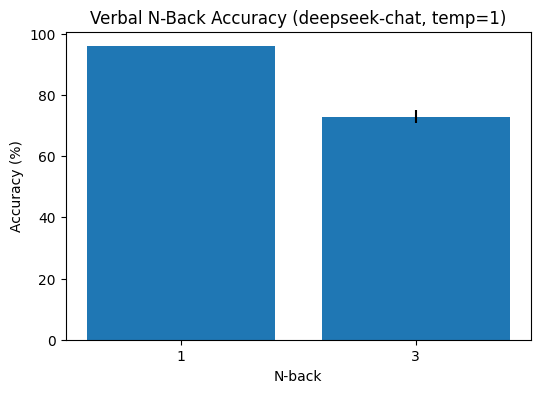

In [9]:
# =========================
# 9. Visualize the accuracy
# =========================
x = [str(n) for n in N_LIST]
y = [summary_stats[n]["accuracy"]["mean"] for n in N_LIST]
yerr = [summary_stats[n]["accuracy"]["stderr"] for n in N_LIST]

plt.figure(figsize=(6, 4))
plt.bar(x, y, yerr=yerr)
plt.xlabel("N-back")
plt.ylabel("Accuracy (%)")
plt.title(f"Verbal N-Back Accuracy ({MODEL_NAME}, temp={TEMPERATURE})")
plt.show()